Based on: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html?highlight=gan

In [1]:
import random

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader

from torchvision.datasets import ImageFolder
from torchvision.transforms import CenterCrop, Compose, Normalize, Resize, ToTensor
from torchvision.utils import make_grid

from fastprogress.fastprogress import master_bar, progress_bar

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from jupyterthemes import jtplot
from IPython.display import HTML

jtplot.style(context="talk")

In [2]:
seed = 47
random.seed(seed)
torch.manual_seed(seed);

In [3]:
# Root directory for dataset
path = "/raid/cs152/data/celeba"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

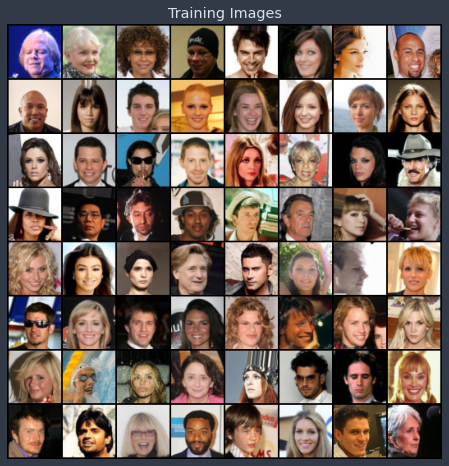

In [4]:
dataset = ImageFolder(
    root=path,
    transform=Compose(
        [
            Resize(image_size),
            CenterCrop(image_size),
            ToTensor(),
            Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)
# Create the dataloader
dataloader = DataLoader(
    dataset, batch_size=batch_size, shuffle=True, num_workers=workers
)

# Decide which device we want to run on
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(
    make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True)
    .cpu()
    .permute(1, 2, 0)
);

In [5]:
def weights_init(m):
    """Custom weights initialization called on generator and discriminator."""
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [7]:
# Create the generator
generator = Generator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
generator.apply(weights_init)

# Print the model
print(generator)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, input):
        return self.main(input)

In [9]:
# Create the Discriminator
discriminator = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
discriminator.apply(weights_init)

# Print the model
print(discriminator)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [10]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.0
fake_label = 0.0

# Setup Adam optimizers for both G and D
optimizerD = Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
update_count = 0

# For each epoch
mb = master_bar(range(num_epochs))
for epoch in mb:

    num_batches = len(dataloader)
    dataiter = iter(dataloader)

    # For each batch in the dataloader
    for batch in progress_bar(range(num_batches), parent=mb):

        real_images, _ = next(dataiter)

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################

        ## Train with all-real batch
        discriminator.zero_grad()
        # Format batch
        real_images = real_images.to(device)
        current_batch_size = real_images.size(0)
        label = torch.full(
            (current_batch_size,), real_label, dtype=torch.float, device=device
        )
        # Forward pass real batch through D
        output = discriminator(real_images).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(current_batch_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = generator(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = discriminator(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        
        generator.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discriminator(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        ############################
        # (3) Log information
        ###########################

        # Output training stats
        if batch % 100 == 0:
            e = f"{epoch:>2}/{num_epochs}"
            b = f"{batch:>4}/{num_batches}"
            dl = f"{errD.item():.3f}"
            dx = f"{D_x:.3f}"
            gl = f"{errG.item():.3f}"
            dgz = f"{D_G_z1:.3f} / {D_G_z2:.3f}"

            print(
                f"[{e}] [{b}] -- DLoss: {dl}, GLoss: {gl}, D(x): {dx}, D(G(z)): {dgz}"
            )

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (update_count % 500 == 0) or (
            (epoch == num_epochs - 1) and (batch == len(dataloader) - 1)
        ):
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
            img_list.append(make_grid(fake, padding=2, normalize=True))

        update_count += 1

[ 0/5] [   0/1583] -- DLoss: 1.823, GLoss: 5.738, D(x): 0.569, D(G(z)): 0.625 / 0.006
[ 0/5] [ 100/1583] -- DLoss: 0.375, GLoss: 6.500, D(x): 0.865, D(G(z)): 0.149 / 0.002
[ 0/5] [ 200/1583] -- DLoss: 0.415, GLoss: 4.628, D(x): 0.823, D(G(z)): 0.123 / 0.017
[ 0/5] [ 300/1583] -- DLoss: 0.586, GLoss: 2.975, D(x): 0.765, D(G(z)): 0.169 / 0.090
[ 0/5] [ 400/1583] -- DLoss: 1.588, GLoss: 2.237, D(x): 0.362, D(G(z)): 0.013 / 0.168
[ 0/5] [ 500/1583] -- DLoss: 0.430, GLoss: 4.540, D(x): 0.779, D(G(z)): 0.070 / 0.028
[ 0/5] [ 600/1583] -- DLoss: 0.417, GLoss: 4.644, D(x): 0.833, D(G(z)): 0.156 / 0.016
[ 0/5] [ 700/1583] -- DLoss: 0.771, GLoss: 3.980, D(x): 0.585, D(G(z)): 0.013 / 0.058
[ 0/5] [ 800/1583] -- DLoss: 0.658, GLoss: 5.876, D(x): 0.883, D(G(z)): 0.357 / 0.006
[ 0/5] [ 900/1583] -- DLoss: 0.760, GLoss: 6.309, D(x): 0.962, D(G(z)): 0.448 / 0.005
[ 0/5] [1000/1583] -- DLoss: 0.699, GLoss: 4.457, D(x): 0.799, D(G(z)): 0.282 / 0.023
[ 0/5] [1100/1583] -- DLoss: 0.775, GLoss: 4.760, D(x)

In [ ]:
# plt.figure(figsize=(10,5))
plt.plot(G_losses, label="Generator")
plt.plot(D_losses, label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.title("Generator and Discriminator Training Loss");

In [ ]:
fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [[plt.imshow(i.permute(1, 2, 0), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

In [ ]:
HTML(ani.to_jshtml())

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

_, (ax1, ax2) = plt.subplots(1, 2)

# Plot the real images
ax1.axis("off")
ax1.set_title("Real Images")
ax1.imshow(
    make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True)
    .cpu()
    .permute(1, 2, 0)
)

# Plot the fake images from the last epoch
ax2.axis("off")
ax2.set_title("Fake Images")
ax2.imshow(img_list[-1].permute(1, 2, 0));